In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc
import grid_tools

import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client(scheduler_file='/glade/scratch/mclong/dask/scheduler.json')
client

Client Scheduler: tcp://10.148.9.242:8786 Dashboard: http://10.148.9.242:8787,Cluster Workers: 232 Cores: 928 Memory: 2784.00 GB


In [3]:
reload(cesm)
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3']+tracer_3d

ds = cesm.open_casedata(case,'atm','cam.h0',varlist,transformed='z3')

print('ds size {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

ds size 3648.21GB

xarray.Dataset {
dimensions:
	lat = 192 ;
	lon = 288 ;
	time = 3347 ;
	zlev = 56 ;

variables:
	float64 lat(lat) ;
	float64 lon(lon) ;
	float64 time(time) ;
	float64 Z3(time, zlev, lat, lon) ;
		Z3:mdims = 1 ;
		Z3:units = m ;
		Z3:long_name = Geopotential Height (above sea level) ;
		Z3:cell_methods = time: mean ;
	float64 plev(zlev) ;
		plev:units = m ;
		plev:long_name = Geopotential height (above sea level) ;
	float64 O2_OCN(time, zlev, lat, lon) ;
		O2_OCN:mdims = 1 ;
		O2_OCN:units = kg/kg ;
		O2_OCN:long_name = O2_OCN ;
		O2_OCN:cell_methods = time: mean ;
	float64 CO2_CROF(time, zlev, lat, lon) ;
		CO2_CROF:mdims = 1 ;
		CO2_CROF:units = mol/mol ;
		CO2_CROF:long_name = CO2_CROF concentration ;
		CO2_CROF:cell_methods = time: mean ;
	float64 CO2_LND(time, zlev, lat, lon) ;
		CO2_LND:mdims = 1 ;
		CO2_LND:units = kg/kg ;
		CO2_LND:long_name = CO2_LND ;
		CO2_LND:cell_methods = time: mean ;
	float64 CO2_T09(time, zlev, lat, lon) ;
		CO2_T09:mdims = 1 ;
		CO2_T0

In [4]:
chunk = {'time':1} #00,'lat':24.,'lon':36.,'zlev':56}
nelements = np.prod(np.array([v for v in chunk.values()])).astype(int)
nbytes = nelements * 8
print('N elements per chunk {:d}\nChunk size in GB {:0.2f}\n'.format(nelements,nbytes / 1e9))

N elements per chunk 1
Chunk size in GB 0.00



In [5]:
ds = ds.chunk(chunk)
ds.chunks

Frozen(SortedKeysDict({u'lat': (192,), u'zlev': (56,), u'lon': (288,), u'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [6]:
area = grid_tools.compute_grid_area(ds.lon.values,ds.lat.values)

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


In [7]:
landfrac = xr.open_dataset('/glade/p/work/mclong/grids/f09_f09.nc')['LANDFRAC'].isel(time=0)
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    time     datetime64[ns] 2007-11-01
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

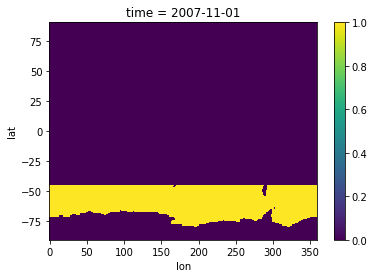

In [8]:
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.).where(landfrac.lat<-44.).fillna(0.)
rmask.plot()

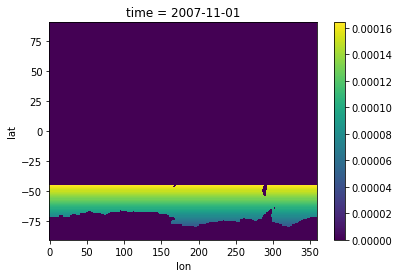

In [9]:
wgt = rmask * area
wgt = wgt/wgt.sum()
wgt = wgt.compute()
wgt.plot()

In [ ]:
%%time
ravg = xr.Dataset()
for v in varlist:
    ravg[v] = (ds[v] * wgt).sum(dim=['lat','lon'])
print ravg

<xarray.Dataset>
Dimensions:   (time: 3347, zlev: 56)
Coordinates:
  * time      (time) float64 730.0 731.0 732.0 733.0 734.0 735.0 736.0 737.0 ...
    plev      (zlev) float64 dask.array<shape=(56,), chunksize=(56,)>
Dimensions without coordinates: zlev
Data variables:
    Z3        (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    O2_OCN    (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_CROF  (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_LND   (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_T09   (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_T09a  (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_T09b  (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_T09c  (time, zlev) float64 dask.array<shape=(3347, 56), chunksize=(1, 56)>
    CO2_T09d  (time, zlev) float64 dask.array<shape=(3347, 56), c

In [ ]:
%%time
ravg = ravg.compute()

In [ ]:
%%time
ravg.CO2.plot()